In [ ]:

import kagglehub
manideep1108_tusimple_path = kagglehub.dataset_download('manideep1108/tusimple')

print('Data source import complete.')


Data source import complete.


In [ ]:
!ls -R /kaggle/

In [ ]:
import os
import cv2
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class TUSimpleDataset(Dataset):
    def __init__(self, data_path, json_mapping, folders, shape=None):
        self.data_path = data_path
        self.json_mapping = json_mapping
        self.folders = folders
        self.shape = shape
        self.data = []

        for folder in self.folders:
            json_file = self.json_mapping[folder]
            json_path = os.path.join(self.data_path, json_file)

            with open(json_path, 'r') as f:
                for line in f:
                    label = json.loads(line.strip())
                    if label["raw_file"].startswith(f"clips/{folder}"):
                        self.data.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.data[idx]
        img_path = os.path.join(self.data_path, label["raw_file"])


        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Image non trouvée : {img_path}")

        img = img / 255.0

        mask = np.zeros((720, 1280), dtype=np.uint8)

        lanes = label["lanes"]
        h_samples = label["h_samples"]

        for lane in lanes:
            for x, y in zip(lane, h_samples):
                if x != -2:
                    cv2.circle(mask, (int(x), int(y)), radius=5, color=1, thickness=-1)

        if self.shape is not None:
            img = cv2.resize(img, (self.shape[1], self.shape[0]))
            mask = cv2.resize(mask, (self.shape[1], self.shape[0]), interpolation=cv2.INTER_NEAREST)

        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return img, mask

data_path = "/kaggle/input/tusimple/TUSimple/train_set/"

json_mapping = {
    '0313-1': 'label_data_0313.json',
    '0313-2': 'label_data_0313.json',
    '0531': 'label_data_0531.json',
    '0601': 'label_data_0601.json'
}

train_folders = ['0313-1', '0313-2']
val_folders = ['0531']

shape = (572, 572)

train_dataset = TUSimpleDataset(data_path, json_mapping, train_folders, shape=shape)
val_dataset = TUSimpleDataset(data_path, json_mapping, val_folders, shape=shape)

print(f"total images train_dataset : {len(train_dataset)}")
print(f"total images val_dataset : {len(val_dataset)}")

img, mask = train_dataset[0]
print("Train Image shape:", img.shape)  # (3, 360, 640)
print("Train Mask shape:", mask.shape)  # (1, 360, 640)

img, mask = val_dataset[0]
print("Val Image shape:", img.shape)  # (3, 360, 640)
print("Val Mask shape:", mask.shape)  # (1, 360, 640)

Nombre total d'images dans train_dataset : 2858
Nombre total d'images dans val_dataset : 358
Train Image shape: torch.Size([3, 572, 572])
Train Mask shape: torch.Size([1, 572, 572])
Val Image shape: torch.Size([3, 572, 572])
Val Mask shape: torch.Size([1, 572, 572])


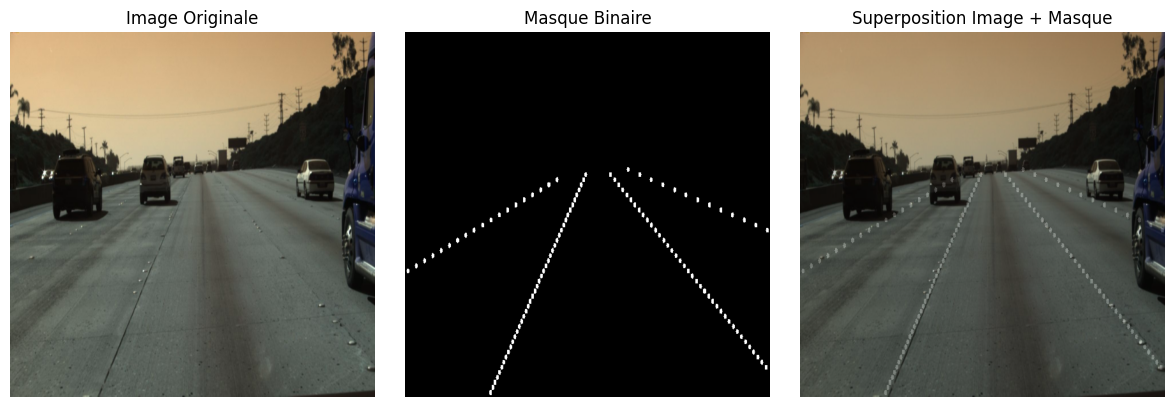

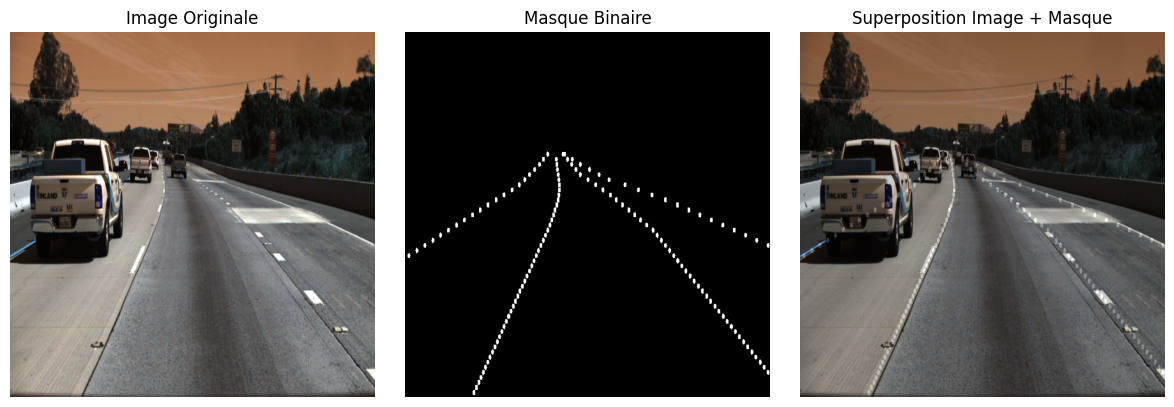

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_n_samples(dataset, n=5):
    plt.figure(figsize=(12, 4 * n))

    for i in range(n):
        img, mask = dataset[i]
        img_np = img.permute(1, 2, 0).cpu().numpy()
        mask_np = mask[0].cpu().numpy()

        mask_rgb = np.stack([mask_np, mask_np, mask_np], axis=-1)


        superimposed = img_np * 0.8 + mask_rgb * 0.2

        plt.subplot(n, 3, i * 3 + 1)
        plt.imshow(img_np)
        plt.title("Image Originale")
        plt.axis("off")

        plt.subplot(n, 3, i * 3 + 2)
        plt.imshow(mask_np, cmap="gray")
        plt.title("Masks")
        plt.axis("off")

        plt.subplot(n, 3, i * 3 + 3)
        plt.imshow(superimposed)
        plt.title(" Image + Masks")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_n_samples(train_dataset, n=1)
visualize_n_samples(val_dataset, n=1)

In [ ]:
batch_size = 8
num_workers = 4

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
)

for images, masks in train_loader:
    print("Batch images - Shape :", images.shape)
    print("Batch masks - Shape :", masks.shape)
    break

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Batch d'images - Shape : torch.Size([8, 3, 572, 572])
Batch de masques - Shape : torch.Size([8, 1, 572, 572])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from tqdm import tqdm

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, inputs):
        return self.conv(inputs)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        self.conv_1 = DoubleConv(in_channels, 16)
        self.maxpool_1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv_2 = DoubleConv(16, 32)
        self.maxpool_2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv_3 = DoubleConv(32, 64)
        self.maxpool_3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv_4 = DoubleConv(64, 128)

        self.upconv_3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0)
        self.conv_up_3 = DoubleConv(128, 64)

        self.upconv_2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0)
        self.conv_up_2 = DoubleConv(64, 32)

        self.upconv_1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2, padding=0)
        self.conv_up_1 = DoubleConv(32, 16)

        self.final_conv = nn.Conv2d(16, out_channels, kernel_size=1)

    def forward(self, inputs):
        x1 = self.conv_1(inputs)
        x2 = self.conv_2(self.maxpool_1(x1))
        x3 = self.conv_3(self.maxpool_2(x2))
        x4 = self.conv_4(self.maxpool_3(x3))

        x = self.upconv_3(x4)
        x = self.conv_up_3(torch.cat([self._crop_tensor(x3, x), x], dim=1))

        x = self.upconv_2(x)
        x = self.conv_up_2(torch.cat([self._crop_tensor(x2, x), x], dim=1))

        x = self.upconv_1(x)
        x = self.conv_up_1(torch.cat([self._crop_tensor(x1, x), x], dim=1))

        return self.final_conv(x)

    def _crop_tensor(self, enc_feature, target):
        _, _, H, W = target.shape
        return enc_feature[:, :, :H, :W]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, val_loader, epochs=10):
    best_val_loss = float('inf')

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")

        for images, masks in progress_bar:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            outputs = nn.functional.interpolate(outputs, size=masks.shape[2:], mode='bilinear', align_corners=False)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            progress_bar.set_postfix(loss=loss.item())

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                outputs = nn.functional.interpolate(outputs, size=masks.shape[2:], mode='bilinear', align_corners=False)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print("Model saved!")


epochs = 10
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)

torch.cuda.empty_cache()
train(model, train_loader, val_loader, epochs=epochs)

Epoch 1/10


Training Epoch 1: 100%|██████████| 358/358 [02:18<00:00,  2.59it/s, loss=0.0901]

Epoch 1/10, Loss: 0.2442


Validation Loss: 0.0995
Model saved!
Epoch 2/10


Training Epoch 2: 100%|██████████| 358/358 [02:21<00:00,  2.52it/s, loss=0.0427]

Epoch 2/10, Loss: 0.0589


Validation Loss: 0.0452
Model saved!
Epoch 3/10


Training Epoch 3: 100%|██████████| 358/358 [02:22<00:00,  2.52it/s, loss=0.0368]

Epoch 3/10, Loss: 0.0394


Validation Loss: 0.0355
Model saved!
Epoch 4/10


Training Epoch 4: 100%|██████████| 358/358 [02:21<00:00,  2.52it/s, loss=0.044]

Epoch 4/10, Loss: 0.0337


Validation Loss: 0.0343
Model saved!
Epoch 5/10


Training Epoch 5: 100%|██████████| 358/358 [02:22<00:00,  2.52it/s, loss=0.0244]

Epoch 5/10, Loss: 0.0311


Validation Loss: 0.0345
Epoch 6/10


Training Epoch 6: 100%|██████████| 358/358 [02:22<00:00,  2.52it/s, loss=0.0281]

Epoch 6/10, Loss: 0.0297


Validation Loss: 0.0296
Model saved!
Epoch 7/10


Training Epoch 7: 100%|██████████| 358/358 [02:22<00:00,  2.52it/s, loss=0.0224]

Epoch 7/10, Loss: 0.0286


Validation Loss: 0.0294
Model saved!
Epoch 8/10


Training Epoch 8: 100%|██████████| 358/358 [02:22<00:00,  2.51it/s, loss=0.0243]

Epoch 8/10, Loss: 0.0279


Validation Loss: 0.0292
Model saved!
Epoch 9/10


Training Epoch 9: 100%|██████████| 358/358 [02:22<00:00,  2.52it/s, loss=0.0266]

Epoch 9/10, Loss: 0.0275


Validation Loss: 0.0285
Model saved!
Epoch 10/10


Training Epoch 10: 100%|██████████| 358/358 [02:22<00:00,  2.51it/s, loss=0.0253]

Epoch 10/10, Loss: 0.0269


Validation Loss: 0.0290


In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

def plot_images(images, true_masks, pred_masks, num_samples=4):
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 10))

    for i in range(num_samples):
        axes[i, 0].imshow(images[i].permute(1, 2, 0))
        axes[i, 0].set_title("Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(true_masks[i][0], cmap="gray")
        axes[i, 1].set_title("Masks")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(pred_masks[i][0], cmap="gray")
        axes[i, 2].set_title("Predicted")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

model.eval()

data_iter = iter(val_loader)
images, true_masks = next(data_iter)
images, true_masks = images.to(device), true_masks.to(device)

with torch.no_grad():
    outputs = model(images) # Use the instantiated model object

pred_masks = torch.sigmoid(outputs).cpu().numpy()
pred_masks = (pred_masks > 0.5).astype(float)

plot_images(images.cpu(), true_masks.cpu(), pred_masks)

NameError: name 'model' is not defined